In [1]:
from pyedflib import EdfReader
import pywt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import re
from timeit import default_timer as timer 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# FILE READING

In [2]:
def read_record_files(dataset_path): 
    """
    Open and store the names of all files and of the ones with seizures

        param dataset_path: the path to the dataset, string

        return files: list of names of all the files, on the form 'chb01/chb01_01'
        return files_seizures: list of names of all the files with seizures, on the form 'chb01/chb01_01'
    """
    records = open(dataset_path + '/' + 'RECORDS_TXT.txt', 'r')
    records_seizures = open(dataset_path + '/' + 'RECORDS-WITH-SEIZURES_TXT.txt', 'r')
    files = records.readlines()
    files_seizures = records_seizures.readlines()
    records.close()
    records_seizures.close()
    return files, files_seizures

# FEATURE CALCULATION 

In [28]:
import mne_features
import hfda

def teager_energy(data):
    sum_values = sum(abs(data[x]**2) if x == 0
                     else abs(data[x]**2 - data[x - 1] * data[x + 1])
                     for x in range(0, len(data) - 1))
    if sum_values == 0:
        return 0  # Avoids log(0) with flat sub-bands/signals
    return np.log10((1 / float(len(data))) * sum_values)
    # return 1 # debugging


def instantaneous_energy(data):
    if sum(i ** 2 for i in data) == 0:
        return 0  # Avoids log(0) with flat sub-bands/signals
    return np.log10((1 / float(len(data))) * sum(i ** 2 for i in data))
    # return 1 # debugging
    
    
def mean(data):
    mean = mne_features.univariate.compute_mean(data)
    return mean
    
    
def variance(data):
    return mne_features.univariate.compute_variance(data)
  
    
def skewness(data):
    return mne_features.univariate.compute_skewness(data)


def zero_crossing(data):
    return mne_features.univariate.compute_zero_crossings(data, threshold = 2.221e-16)


def kurtosis(data):
    return mne_features.univariate.compute_kurtosis(data)


def spect_entropy(data):
    return mne_features.univariate.compute_spect_entropy(250, data)


def hfd(data, k_max=None):
    return hfda.measure(data, 10)
    
    
def pfd(data):
    N_delta = np.diff(np.signbit(data)).sum()
    N = len(data)
    return (np.log10(N))/(np.log10(N) + np.log10((N/N+0.4*N_delta)))


# FEATURE EXTRACTION

In [4]:

import math
def get_seizure_start_end(fname_path): 
    """
    Finds the start time and end time for the seizure from the summary file for each patient. 
    There can be more than one seizure per file

        param: fname_path: the path to the file with the seizure, string

        return start_time: when the seizure starts, list of strings  
        return end_time: when the seizure ends, list of strings
    """
    start_time = []
    end_time = []
    summary_file = open(fname_path[:-7] + '-summary.txt','r')
    for line in summary_file: 
        seizure_start = re.search("Seizure\s\d\sStart", line)
        if seizure_start is not None: 
            start_time += line.split()[4:][:-1]
        seizure_end = re.search("Seizure\s\d\sEnd", line)
        if seizure_end is not None: 
            end_time += line.split()[4:][:-1]
    summary_file.close()
    return start_time, end_time


def calculate_features(dwt, feature_vector):
    """
    Calculating features from the decomposition levels

        param dwt: the dwt levels, list
        param fature_vector: the vector to add more features to

        return feature_vector: updated feature_vector with onw more row of features
    """
    feature = []
    for dwt_value in dwt:
        feature += [teager_energy(dwt_value), 
                           instantaneous_energy(dwt_value), 
                           mean(dwt_value), 
                           variance(dwt_value), 
                           pfd(dwt_value)]        
    feature_vector.append(feature)
    return feature_vector


def generate_features_from_files(dataset_path, files, files_seizures, Fs): 
    """
    Reads the signal for each patient, for each trail and each channel. 
    TODO: the code now reads only the files for patient 12 to reduce runtime 
    Each signal is decomposed into 4 levels using DWT. 
    From the four levels two features are found: instantaneous energy and teager energy
    TODO: add more features when runtime is better
    These are added to two feature vectors for all the patients: one with and one without seizure 

        param dataset_path: the path to the dataset, string
        param files: names of all the files, on the form 'chb01/chb01_01', list
        param files_seizures: names of all the files with seizures, on the form 'chb01/chb01_01', list
        param Fs: sampling frequency

        return features_seizures: features for signals with seizures, list
        return features_no_seizures: features for signals without signals, list
    """

    # Variables
    features_no_seizure = []
    features_seizure = []

    # For all files in the whole dataset
    for file in files:
        if (file.startswith('chb12/')): # TODO: remove this to run the code for all patients. Keep it to make the code run faster and debugging
            print('File', file) # debugging
            fname_path = dataset_path + '/' + file.strip()
            f = EdfReader(fname_path)
            channel_names = f.getSignalLabels() # TODO: can I come up with a better solution?

            for channel in range(len(channel_names)):
                signal = f.readSignal(channel)

                if file in files_seizures: # If the file has a seizure we need to separate the seizure signal from the non-seizure signal
                    # Get seizure interval from files: 
                    start_time, end_time = get_seizure_start_end(fname_path)

                    # For each seizure we collect the signal to do dwt and find features
                    for i in range(len(start_time)): 
                        seizure_start = int(start_time[i])
                        seizure_end = int(end_time[i])
                        seizure_signal = signal[int(seizure_start*Fs):int(seizure_end*Fs)]
                        if len(seizure_signal) > 0 : # get rid of signals with lenght 0, TODO: why is chb12/chb12_11 []?
                            dwt = pywt.wavedec(seizure_signal, 'bior2.2', level=4)
                            features_seizure = calculate_features(dwt, features_seizure)

                else: # no seizure in file
                    dwt = pywt.wavedec(signal, 'bior2.2', level=4)
                    features_no_seizure = calculate_features(dwt, features_no_seizure)
                    
    return features_no_seizure, features_seizure


dataset_path = "C:/Users/marieov/OneDrive - NTNU/NTNU/9. semester/Project thesis/github/Project-thesis/CHB_MIT" # TODO: in config
Fs = 256 # TODO: downsample to 128

files, files_seizures = read_record_files(dataset_path)
start = timer()
features_no_seizure, features_seizure = generate_features_from_files(dataset_path, files, files_seizures, Fs)
print("Time:", timer()-start)


File chb12/chb12_06.edf

File chb12/chb12_08.edf

File chb12/chb12_09.edf

File chb12/chb12_10.edf

File chb12/chb12_11.edf

File chb12/chb12_19.edf

File chb12/chb12_20.edf

File chb12/chb12_21.edf

File chb12/chb12_23.edf

File chb12/chb12_24.edf

File chb12/chb12_27.edf

File chb12/chb12_28.edf

File chb12/chb12_29.edf

File chb12/chb12_32.edf

File chb12/chb12_33.edf

File chb12/chb12_34.edf

File chb12/chb12_35.edf

File chb12/chb12_36.edf

File chb12/chb12_37.edf

File chb12/chb12_38.edf

File chb12/chb12_39.edf

File chb12/chb12_40.edf

File chb12/chb12_41.edf

File chb12/chb12_42.edf

Time: 449.6367977000773


# MACHINE LEARNING PREPROCESSING

In [22]:
features = []

def create_labels(features_no_seizure, features_seizure):
    """
    Creating labels for the features found
    0 is no seizure
    1 is seizure

        param features_seizures: features for signals with seizures, list
        param features_no_seizures: features for signals without signals, list

        return labels: labels 0 or 1, list
    """
    labels_no_seizure = np.zeros(len(features_no_seizure))
    labels_seizure = np.ones(len(features_seizure))
    labels = np.append(labels_no_seizure, labels_seizure)
    return labels

labels = create_labels(features_no_seizure, features_seizure)
features += features_no_seizure
features += features_seizure

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

# RANDOM FOREST 

Most important features [4, 19, 14, 9, 24, 2, 6, 21, 16, 18, 3, 11, 8, 0, 5, 1, 10, 15, 7, 23, 13, 17, 12, 20, 22]
Accuracy test:  0.996 Accuracy train:  0.997 Error precentage 0.43 f1 score:  0.945 Precision:  0.998 Recall:  0.902


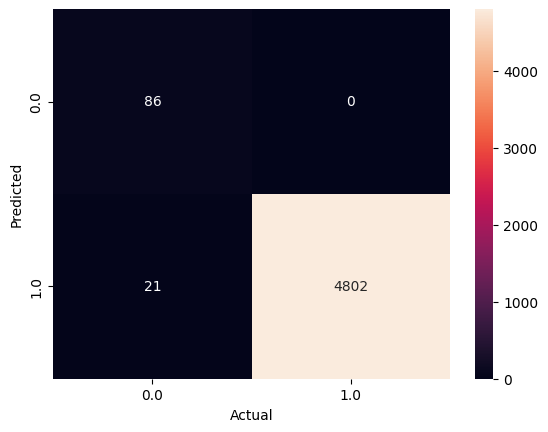

In [34]:
def confusion_matrix_heatmap(target, predicted, perc=False):
    """
    Prints a heatmap for better interpration of the results
    
        param target: the labels for the test set, list
        param predicted: the predicted values for the test set, list
        
        return:
    """
    plt.figure()
    data = {'y_Actual': target, 'y_Predicted': predicted}
    df = pd.DataFrame(data, columns=['y_Predicted','y_Actual'])
    c_matrix_l = pd.crosstab(df['y_Predicted'], df['y_Actual'],
        rownames=['Predicted'], colnames=['Actual'])
    if perc:
        sns.heatmap(c_matrix_l/np.sum(c_matrix_l),
            annot=True, fmt='.2%', cmap='Blues')
    else:
        sns.heatmap(c_matrix_l, annot=True, fmt='d')


def get_metrices(y_test, y_train, y_rf_predict_test, y_rf_predict_train, _average="macro"): #, cmatrix_plot=False, _print=False, _title="", _average="micro", "macro"
    """
    Prints different values to measure the preformance of the algorithm
    
        param y_test: the labels for the test set, list
        param y_train: the labels for the training set, list
        param y_rf_predict_test: the predicted values for the test set, list
        param y_rf_predict_train: the predicted values for the test set, list
        
        return:        
    """    
    _acc_test = round(accuracy_score(y_test, y_rf_predict_test), 3)
    _acc_train = round(accuracy_score(y_train, y_rf_predict_train), 3)
    _fscore = round(f1_score(y_test, y_rf_predict_test, average=_average), 3)
    _precision = round(precision_score(y_test, y_rf_predict_test, average=_average), 3)
    _recall = round(recall_score(y_test, y_rf_predict_test, average=_average), 3)
    _errors = abs(y_rf_predict_test - y_test)
    _error_precentage = round(np.sum(_errors)/len(_errors)*100, 2)
    
    print( "Accuracy test: ",_acc_test, "Accuracy train: ", _acc_train, "Error precentage", _error_precentage, "f1 score: ", _fscore, "Precision: ", _precision, "Recall: ", _recall)
    # return _acc_test,_acc_train,_fscore,_precision,_recall
    
    
def find_important_features(rf): 
    """
    Prints the features in decreasing order (first is the most important)
    
        param: random forest after fitting
        
        return:
    """
    important_features_dict = {}
    for xx, i in enumerate(rf.feature_importances_):
        important_features_dict[xx] = i
    important_features_list = sorted(important_features_dict, key=important_features_dict.get, reverse = True)
    print('Most important features', important_features_list)

    
def random_forest(X_train, X_test, y_train, y_test):
    """
    Runs the random forest classifier
    
        param X_train: training data, matrix with features as rows and samples as columns
        param X_test: test data, matrix with features as rows and samples as columns
        param y_train: labels for training set, list
        param y_test: labels for test set, list
        
        return:
    """
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train, y_train)
    
    y_rf_predict_test = rf.predict(X_test)
    y_rf_predict_train = rf.predict(X_train)

    find_important_features(rf)
    get_metrices(y_test, y_train,y_rf_predict_test, y_rf_predict_train)
    confusion_matrix_heatmap(y_test, y_rf_predict_test)


# running the random forest classifier
random_forest(X_train, X_test, y_train, y_test)